# Imports:

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from termcolor import colored
import cv2

# Load Coin Dataset:

In [31]:
# Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir = '/content/drive/MyDrive/coin_classifier/'

# Local
base_dir = '.'

dataset_dir = '%s/images/' % base_dir
model_dir = '%s/coin_classifier_model/' % base_dir

batch_size = 16
img_size = (512, 512)

In [32]:
labels = open('%s/coin_classifier_labels.txt' % base_dir).readlines()
labels = list(map(lambda x: x.strip(), labels))

zoom_layer = layers.RandomZoom((0, 0.2))

def zoom(img):
  return zoom_layer(img)

def to_grayscale(x):
  return ((0.21 * x[:,:,:1]) + (0.72 * x[:,:,1:2]) + (0.07 * x[:,:,-1:])) / 255

def deriv_filter(x):
  x_deriv_kernel = [
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
  ]
  y_deriv_kernel = [
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
  ]
  x_deriv = cv2.filter2D(x, -1, np.array(x_deriv_kernel))
  y_deriv = cv2.filter2D(x, -1, np.array(y_deriv_kernel))
  x = np.sqrt(x_deriv ** 2 + y_deriv ** 2)
  x = np.reshape(x, (img_size[0], img_size[1], 1))
  x = np.clip(x, 0, 1)
  return x

def preprocess(x):
  x = to_grayscale(x)
  x = deriv_filter(x)
  x = zoom(x)
  return x

datagen = preprocessing.image.ImageDataGenerator(
  rotation_range=15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  validation_split=0.1,
  preprocessing_function=preprocess
)

train_generator = datagen.flow_from_directory(
  dataset_dir,
  target_size=img_size,
  batch_size=batch_size,
  subset="training"
)
val_generator = datagen.flow_from_directory(
  dataset_dir,
  target_size=img_size,
  batch_size=batch_size,
  subset="validation"
)

Found 3696 images belonging to 84 classes.
Found 374 images belonging to 84 classes.


# Display Coin Images:

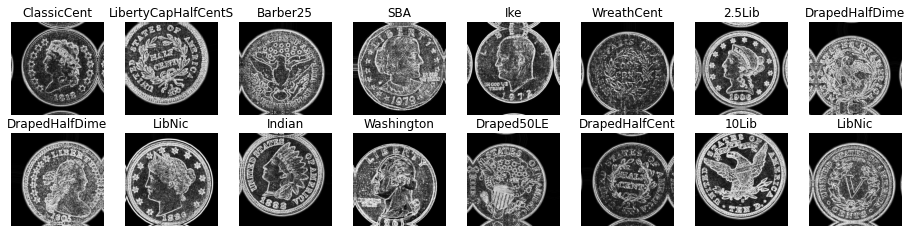

In [33]:
fig = plt.figure(figsize=(16, 16))
X_batch, y_batch = train_generator.next()
for i in range(min(len(X_batch), 64)):
  fig.add_subplot(8, 8, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  plt.title(labels[np.argmax(y_batch[i])])

# Create CNN:

In [34]:
class RemoveRedundantChannels(layers.Layer):
    def __init__(self, **kwargs):
        super(RemoveRedundantChannels, self).__init__(**kwargs)

    def call(self, x):
        return tf.reshape(x[:,:,:,0], (-1, img_size[0], img_size[1], 1))

In [30]:
model = models.Sequential([
  layers.Conv2D(128, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3), padding='same'),
  layers.BatchNormalization(),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((4, 4)),
  layers.Dropout(0.1),
  
  layers.Conv2D(256, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(256, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((4, 4)),
  layers.Dropout(0.25),

  layers.Conv2D(512, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(512, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((4, 4)),
  layers.Dropout(0.5),
  
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(84, activation='softmax'),
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 512, 512, 128)     3584      
_________________________________________________________________
batch_normalization_54 (Batc (None, 512, 512, 128)     512       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 510, 510, 128)     147584    
_________________________________________________________________
batch_normalization_55 (Batc (None, 510, 510, 128)     512       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 127, 127, 128)     0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 125, 125, 256)    

# Train Model:

In [35]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=10)

2021-11-10 21:19:15.944654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
  4/231 [..............................] - ETA: 1:37:40 - loss: 56.4318 - accuracy: 0.0156    

KeyboardInterrupt: 

# Save/Load Model:

## Save model:

In [ ]:
model.save('%s/coin_classifier_save' % base_dir)

## Save model using TFLite:

In [36]:
converter = tf.lite.TFLiteConverter.from_saved_model('%s/coin_classifier_save' % base_dir)
tflite_model = converter.convert()
with open('%s/coin_classifier.tflite' % base_dir, 'wb') as f:
  f.write(tflite_model)

2021-10-23 02:16:56.374796: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-10-23 02:16:56.374813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2021-10-23 02:16:56.374817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2021-10-23 02:16:56.378038: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: ./coin_classifier_save
2021-10-23 02:16:56.384552: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-10-23 02:16:56.384573: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: ./coin_classifier_save
2021-10-23 02:16:56.405752: I tensorflow/cc/saved_model/loader.cc:211] Restoring SavedModel bundle.
2021-10-23 02:16:56.514504: I tensorflow/cc/saved_model/loader.cc:195] Running initialization op on SavedModel bundle at path: ./coin_c

## Load model:

In [17]:
model = models.load_model('%s/coin_classifier_save' % base_dir)

## Load model using TFLite:

In [6]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='%s/coin_classifier.tflite' % base_dir)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test Images:

In [18]:
correct = {}
total = {}
for i in range(len(labels)):
  correct[i] = 0
  total[i] = 0
for X, y in dataset:
  preds = [np.argmax(pred) for pred in model.predict(X)]
  for i, pred in enumerate(preds):
    true = y[i].numpy()
    if pred == true:
      correct[true] += 1
    total[true] += 1
for label, count in correct.items():
  acc = count / total[label]
  print('%s: %.2f' % (labels[label], acc))

2021-10-23 01:59:30.060171: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


10Ind: 1.00
10Lib: 0.90
1793HalfCent: 0.83
2.5Ind: 0.94
2.5Lib: 0.96
20Lib: 0.93
20Saint: 0.99
3CentNic: 0.99
3CentSil: 0.94
3Gold: 0.97
5Ind: 0.83
5Lib: 0.88
Barber10: 0.96
Barber25: 0.88
Barber50: 0.94
BraidedCent: 0.88
BraidedHalfCent: 0.93
Buffalo: 0.99
Capped10Lg: 0.85
Capped2.5: 0.92
Capped25Lg: 0.48
Capped50: 0.94
CappedBust5: 0.87
CappedHalfDime: 0.90
CappedHead5: 0.90
ChainCent: 0.87
Classic2.5: 0.94
Classic5: 0.88
ClassicCent: 0.87
ClassicHalfCent: 0.73
CoronetCent: 0.86
Draped10LE: 0.77
Draped10SE: 0.68
Draped25LE: 0.88
Draped25SE: 0.79
Draped50LE: 0.72
Draped50SE: 0.73
DrapedBust10LE: 0.80
DrapedBust10SE: 0.97
DrapedBust5LE: 0.70
DrapedBust5SE: 0.69
DrapedBustCent: 0.86
DrapedBustR2.5LE: 0.90
DrapedDolLE: 0.82
DrapedHalfCent: 0.82
DrapedHalfDime: 0.36
DrapedHalfDimeLE: 0.65
FlowingDol: 0.73
FlowingHalf: 0.88
FlowingHalfDime: 0.86
Flying: 0.95
Franklin: 0.99
GoldDollar1: 0.99
GoldDollar2: 0.83
GoldDollar3: 0.82
Ike: 0.89
Indian: 0.97
Jefferson: 0.93
Kennedy: 0.97
LibNic: 0.9

0.0
1: CappedHalfDime
2: Morgan
3: LibNic
4: Peace
5: 3CentNic


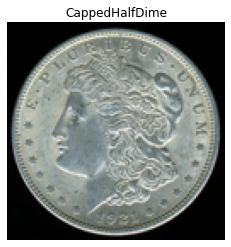

In [84]:
img_name = 'Morgan_o.jpg'
label = img_name.split('_')[0]

img = Image.open('%s/test_images/%s' % (base_dir, img_name))
img = img.resize(size=(img_size, img_size))
img_data = np.divide(preprocessing.image.img_to_array(img), 255.0)
img_dataset = tf.data.Dataset.from_tensors([img_data])
byte_data = img_data.tobytes()
byte_list = list(byte_data)

with open('img.txt', 'w') as f:
  f.write(str(byte_data))

# For Standard Model
# prediction = model.predict(img_dataset)[0]

# For TFLite Model
interpreter.set_tensor(input_details[0]['index'], [img_data])
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])[0]

ranked = np.argsort(prediction)

def get_color(index):
  if index == -1:
    return 'green' if labels[ranked[index]] == label else 'red'
  else:
    return 'yellow' if labels[ranked[index]] == label else 'white'

for i in range(-1,-6,-1):
  print(colored('%d: %s' % (abs(i), labels[ranked[i]]), get_color(i)))

plt.title(labels[np.argmax(prediction)])
plt.axis('off')
plt.imshow(img_data)